<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Missing Data](#miss) <br>
[4. Outlier Data](#out) <br>
[5. Dirty Data](#dirty) <br>
$\;\;\;\;$[5.1 Date Handling](#date) <br>
$\;\;\;\;$[5.2. Seasons](#season) <br>
$\;\;\;\;$[5.3. Customer Location](#cust_loc) <br>
$\;\;\;\;$[5.4. Warehouses](#ware) <br>
$\;\;\;\;$[5.5. Shopping Cart](#shop) <br>
$\;\;\;\;$[5.6. Order Price](#op) <br>
$\;\;\;\;$[5.7. Happy Customer](#happy) <br>
$\;\;\;\;$[5.8. Expedited Delivery](#ex) <br>
[6. References](#Ref) <br>

<div class="alert alert-block alert-success">
    
## 1.  Introduction  <a class="anchor" name="Intro"></a>

We will be dealing with three different CSV files and will address the following issues:  
* missing data - We need to impute missing data using an apropriate linear model.
* outlier data - We need to filter out any outlier values w.r.t delivery charges.
* dirty data - We need to clean the whole csv by correcting any dirty data.

<div class="alert alert-block alert-success">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download("vader_lexicon")
from math import radians, sin, cos, sqrt, atan2 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
    
## 3.  Missing Data  <a class="anchor" name="miss"></a>

In [2]:
# reading missing data 
missing_data = pd.read_csv("./32776705_missing_data.csv")
missing_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD064173,ID0582914901,2022-09-26,Thompson,"[('Toshika 750', 2), ('Candle Inferno', 1)]",9070,103.994,-37.836908,144.894564,25,Spring,True,5.34711,whodat cool daddy-o,True
1,ORD331771,ID0472236184,2022-07-16,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,NaN,-37.798961,144.966522,0,Winter,True,2.20176,i love olivia love this phone..works well look...,True
2,ORD403407,ID0575397935,2022-06-06,Nickolson,"[('Toshika 750', 1), ('pearTV', 2)]",16940,34.865,-37.821234,144.983738,50,Winter,False,1.28162,great phone extremely happy with the phone the...,True
3,ORD400298,ID0575384675,2022-07-30,Nickolson,"[('Thunder line', 2), ('Toshika 750', 2), ('Un...",20200,39.068,-37.819371,144.981888,50,Winter,True,1.08831,good quality the phone was nice and compact,True
4,ORD442816,ID3208518296,2022-01-21,Nickolson,"[('iAssist Line', 2), ('Thunder line', 1), ('C...",7490,59.665,-37.805371,144.964572,25,Summer,False,1.53576,very nice phone! very nice phone!,True


From below we can see that there are 3 columns with missing values:
* nearest_warehouse
* delivery_charges
* distance_to_nearest_warehouse

In [3]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              400 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               450 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   delivery_discount              500 non-null    int64  
 10  season                         500 non-null    object 
 11  is_expedited_delivery          500 non-null    bool   
 12  distance_to_nearest_warehouse  450 non-null    flo

We have 15 different columns (mixture of categorical and numerical) in our missing data. We will first start working on distance_to_nearest_warehouse and nearest_warehouse by comparing the warehouse details from the warehouse data.

In [4]:
# opening warehouse csv to get location of different warehouses
warehouses = pd.read_csv("./warehouses.csv")
warehouses

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [5]:
# creating a function to get distance between 2 points

def nearest_distance(lat1, lon1, lat2, lon2):
    
    '''
    Function to calculatethe nearest distance between 2 points based on their latitudes and longitudes.
    Here, radius of Earth is assumed to be 6378 kms.
    
        Input Parameters:
            lat1: latitude value
            lon1: longitude value
            lat2: latitude value 
            lon2: longitude value
    
        Output:
            Distance between 2 points.
    '''
    
    # radius in Kms
    radius = 6378 

    #converting customer latitudes and longitudes to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
   
    # calculating differences between latitudes and longitudes  
    lat_diff = lat2- lat1
    lon_diff = lon2 - lon1 
    
   # applying Haversine formula to calculate nearest distance
    a = sin(lat_diff / 2)**2 + cos(lat1) * cos(lat2) * sin(lon_diff / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = round(radius * c, 5)
    
    return distance

In [6]:
# list of customer locations as a tuple
customer_locs = list(zip(missing_data['customer_lat'], missing_data['customer_long']))
len(customer_locs)

500

In [7]:
# storing correct warehouse and its distance in 2 seperate lists
warehouse_distance = []
correct_closest_warehouse = []

for cust_lat, cust_lon in customer_locs:
    min_dist = float('inf') # setting min distance to be the max known value
    closest_warehouse = None
    # iterating over every row of warehouses df
    for idx, row in warehouses.iterrows():
        dist = nearest_distance(cust_lat, cust_lon, row['lat'], row['lon']) # calculating distance
        if dist < min_dist:
            min_dist = dist
            closest_warehouse = row['names']
    warehouse_distance.append(min_dist)
    correct_closest_warehouse.append(closest_warehouse)

In [8]:
# creating a copy of missing data to make changes 
copy = missing_data.copy()
copy['warehouse_name'] = correct_closest_warehouse
copy['warehouse_dist'] = warehouse_distance

In [9]:
# verifying if we got correct nearest_warehouse by cross checking with non null values.
copy2 = copy[copy['nearest_warehouse'].notnull()]

if copy2['nearest_warehouse'].equals(copy2['warehouse_name']):
    print("Calculated output matches nearest_warehouse values.")
else:
    print("Calculated output does not matches nearest_warehouse values.")

Calculated output matches nearest_warehouse values.


In [10]:
# verifying if we got correct distance_to_nearest_warehouse by cross checking with non null values.
copy3=copy[copy['distance_to_nearest_warehouse'].notnull()]

if copy3['distance_to_nearest_warehouse'].equals(copy3['warehouse_dist']):
    print("Calculated output matches distance_to_nearest_warehouse values.")
else:
    print("Calculated output does not matches distance_to_nearest_warehouse values.")


Calculated output matches distance_to_nearest_warehouse values.


In [11]:
# imputing missing values with calculated values 
missing_data['nearest_warehouse'].fillna(copy['warehouse_name'], inplace=True)
missing_data['distance_to_nearest_warehouse'].fillna(copy['warehouse_dist'], inplace=True)

In [12]:
# checking null values 
missing_data.isnull().sum()

order_id                          0
customer_id                       0
date                              0
nearest_warehouse                 0
shopping_cart                     0
order_price                       0
delivery_charges                 50
customer_lat                      0
customer_long                     0
delivery_discount                 0
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse     0
latest_customer_review            0
is_happy_customer                 0
dtype: int64

Next, we will focus on delivery charges..
To impute null values of delivery charges, We will make 4 predicitive models depending on seasons. We will focus on Multiple Linear regression model for deliery charges(without any discounts) which depends on:  
* Distance between customer and nearest warehouse  
* Whether the customer asked for an expedited delivery
* Whether the customer was happy with his/her last purchase


In [13]:
# need non null data to create model
non_null_df = missing_data[missing_data['delivery_charges'].isnull() == False]

# creating copy to avoid slicing dataframe warnings
model_df = non_null_df.copy()

# removing discount from delivery charge
model_df.loc[:, 'delivery_charges_before_discount'] = model_df[['delivery_discount', 'delivery_charges']].apply(lambda x: x['delivery_charges'] / (1 - (x['delivery_discount']/100)), axis=1)
model_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,delivery_charges_before_discount
0,ORD064173,ID0582914901,2022-09-26,Thompson,"[('Toshika 750', 2), ('Candle Inferno', 1)]",9070,103.994,-37.836908,144.894564,25,Spring,True,5.34711,whodat cool daddy-o,True,138.658667
2,ORD403407,ID0575397935,2022-06-06,Nickolson,"[('Toshika 750', 1), ('pearTV', 2)]",16940,34.865,-37.821234,144.983738,50,Winter,False,1.28162,great phone extremely happy with the phone the...,True,69.730000
3,ORD400298,ID0575384675,2022-07-30,Nickolson,"[('Thunder line', 2), ('Toshika 750', 2), ('Un...",20200,39.068,-37.819371,144.981888,50,Winter,True,1.08831,good quality the phone was nice and compact,True,78.136000
4,ORD442816,ID3208518296,2022-01-21,Nickolson,"[('iAssist Line', 2), ('Thunder line', 1), ('C...",7490,59.665,-37.805371,144.964572,25,Summer,False,1.53576,very nice phone! very nice phone!,True,79.553333
5,ORD040107,ID0283334505,2022-11-16,Thompson,"[('Toshika 750', 1), ('iAssist Line', 1), ('Ca...",7405,105.217,-37.800611,144.949983,0,Spring,True,1.36692,love it! perfect for such $,True,105.217000


Now, we will generate four different dataframes for four different seasons and model them accordingly, but before we will handle required boolean columns for our model prediction.

In [14]:
# handling boolean columns 
model_df['is_happy_customer'] = model_df['is_happy_customer'].astype(int)
model_df['is_expedited_delivery'] = model_df['is_expedited_delivery'].astype(int)

In [15]:
# creating seasonal datas
Summer_model_df = model_df[model_df['season'] =='Summer']
Winter_model_df = model_df[model_df['season'] =='Winter']
Autumn_model_df = model_df[model_df['season'] =='Autumn']
Spring_model_df = model_df[model_df['season'] =='Spring']

In [16]:
# Defining independent variables for 4 models 
X_summer = Summer_model_df[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_winter = Winter_model_df[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_autumn = Autumn_model_df[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_spring = Spring_model_df[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]

In [17]:
# Defining dependent variable - actual delivery charge( i.e before any discount)
Y_summer= Summer_model_df['delivery_charges_before_discount']
Y_winter= Winter_model_df['delivery_charges_before_discount']
Y_autumn= Autumn_model_df['delivery_charges_before_discount']
Y_spring= Spring_model_df['delivery_charges_before_discount']

By using similar data for training and testing, one may reduce the effects of data inconsistencies and better understand the model's properties. After a model has been trained using the training set, it is tested by making predictions against the test set. The following step splits data into training and testing sets.

In [18]:
# splitting data into training and test sets
X_summer_train, X_summer_test, Y_summer_train, Y_summer_test = train_test_split(X_summer, Y_summer, test_size = 0.2, random_state = 42)
X_winter_train, X_winter_test, Y_winter_train, Y_winter_test = train_test_split(X_winter, Y_winter, test_size = 0.2, random_state = 42)
X_autumn_train, X_autumn_test, Y_autumn_train, Y_autumn_test = train_test_split(X_autumn, Y_autumn, test_size = 0.2, random_state = 42)
X_spring_train, X_spring_test, Y_spring_train, Y_spring_test = train_test_split(X_spring, Y_spring, test_size = 0.2, random_state = 42)

In [19]:
#instantiationg an object from this class
LR = LinearRegression()

In [20]:
# getting all parameters of linear regression
LR.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [21]:
#setting a param grid to choose parameters from 
param_grid = {'fit_intercept': [True, False],
              'positive': [True, False],
              'n_jobs': [-1],
             'copy_X' : [True, False]}

In [22]:
# creating a function to get the best parameters
def best_params(param_grid, model_instance, scoring, independent_df, dependent_df):
    '''
    Function returns the best parameters for the model to
    give a high accuracy depedning on input parameters.
    (With CV= 5)
    
        Input Parameters:
            param_grid: A python dictionary 
            model_instance: A model object 
            scoring: Accuracy score method
            independent_df: A pandas dataframe with independent features
            dependent_df: A pandas dataframe with a dependent feature
            
        Output:
            Function returns the best paramters. 
    '''
    # using grid search to search for best parameters
    grid = GridSearchCV(model_instance, param_grid, cv=5, scoring= scoring) 
    grid.fit(independent_df, dependent_df)
    
    print("With these parameters R-squared will be", grid.best_score_)
    return grid.best_params_

In [23]:
Summer_parameters = best_params(param_grid, LR, 'r2', X_summer, Y_summer)
Summer_parameters

With these parameters R-squared will be 0.9946864064851988


{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}

In [24]:
winter_parameters = best_params(param_grid, LR, 'r2', X_winter, Y_winter)
winter_parameters

With these parameters R-squared will be 0.9893830231412684


{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}

In [25]:
Autumn_parameters = best_params(param_grid, LR, 'r2', X_autumn, Y_autumn)
Autumn_parameters

With these parameters R-squared will be 0.9860745520046708


{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}

In [26]:
Spring_parameters = best_params(param_grid, LR, 'r2', X_spring, Y_spring)
Spring_parameters

With these parameters R-squared will be 0.9953543501861759


{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}

In [27]:
# creating a function to run model
def fit_and_test(model, Xtrain_data, Xtest_data, Ytrain_data, Ytest_data ):
    '''
    This function fits a model on training data and creates prediction test data.
    
        Input Parameters:
            model: A model with appropriate paramters (if needed)
            Xtrain_data: A pandas dataframe of training data for independent features
            Xtest_data: A pandas dataframe of testing data for independent features
            Ytrain_data: A pandas dataframe of training data for dependent feature
            Ytest_data: A pandas dataframe of testing data for dependent feature
            
        Output:
            score: r2 score
            pred: Predicted values of test data          
    '''
    
    # we will fit the model using training data 
    model.fit(Xtrain_data, Ytrain_data)
    # predicting values
    pred = model.predict(Xtest_data)
    # getting the r2score
    score = r2_score(Ytest_data,pred)
    
    return score, pred

In [28]:
# making predictions using the above function
summer_model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = -1, positive = True)
summer_score, Y_summer_prediction = fit_and_test(summer_model, X_summer_train, X_summer_test, Y_summer_train , Y_summer_test)

winter_model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = -1, positive = True)
winter_score, Y_winter_prediction = fit_and_test(winter_model, X_winter_train, X_winter_test, Y_winter_train, Y_winter_test)

autumn_model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = -1, positive = True)
autumn_score, Y_autumn_prediction = fit_and_test(autumn_model, X_autumn_train, X_autumn_test, Y_autumn_train, Y_autumn_test )

spring_model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = -1, positive = True)
spring_score, Y_spring_prediction = fit_and_test(spring_model, X_spring_train, X_spring_test, Y_spring_train, Y_spring_test )



In [29]:
summer_score

0.9961279569260189

In [30]:
winter_score

0.9836056083770248

In [31]:
autumn_score

0.9814891789537716

In [32]:
spring_score

0.9973618446127221

Now, we'll use the model we just developed to fill in the missing values in the delivery charge column. 


In [33]:
# need missing data to make predictions
null_df = missing_data[missing_data['delivery_charges'].isnull() == True]
missing_df = null_df.copy() # creating copy to avoid slicing dataframe warnings

# handling boolean values
missing_df['is_expedited_delivery'] = missing_df['is_expedited_delivery'].astype('int')
missing_df['is_happy_customer'] = missing_df['is_happy_customer'].astype('int')

In [34]:
# creating 4 seasonal datas
missing_df_summer = missing_df[missing_df['season']== 'Summer']
missing_df_winter = missing_df[missing_df['season']== 'Winter']
missing_df_autumn = missing_df[missing_df['season']== 'Autumn']
missing_df_spring = missing_df[missing_df['season']== 'Spring']

In [35]:
# Defining new independent variables for 4 models  (for null records)
X_summer_new = missing_df_summer[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_winter_new = missing_df_winter[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_autumn_new = missing_df_autumn[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]
X_spring_new = missing_df_spring[['distance_to_nearest_warehouse', 'is_expedited_delivery', 'is_happy_customer']]

In [36]:
# making predictions for missing data 
# these are the predicted delivery charges before any discount
y_summer_pred_new = summer_model.predict(X_summer_new)
y_winter_pred_new = winter_model.predict(X_winter_new)
y_autumn_pred_new = autumn_model.predict(X_autumn_new)
y_spring_pred_new = spring_model.predict(X_spring_new)

In [37]:
# Creating a new column in missing_df to add predicted pre-discounted delivery charges
missing_df.loc[missing_df['season']== 'Summer', 'predicted_delivery_charge_before_discount'] = list(y_summer_pred_new)
missing_df.loc[missing_df['season']== 'Winter', 'predicted_delivery_charge_before_discount'] = list(y_winter_pred_new)
missing_df.loc[missing_df['season']== 'Autumn', 'predicted_delivery_charge_before_discount'] = list(y_autumn_pred_new)
missing_df.loc[missing_df['season']== 'Spring', 'predicted_delivery_charge_before_discount'] = list(y_spring_pred_new)


In [38]:
missing_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,predicted_delivery_charge_before_discount
1,ORD331771,ID0472236184,2022-07-16,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,NaN,-37.798961,144.966522,0,Winter,1,2.20176,i love olivia love this phone..works well look...,1,84.936124
7,ORD031271,ID1449496101,2022-11-04,Nickolson,"[('Alcon 10', 1), ('iAssist Line', 1)]",11175,NaN,-37.823971,144.984788,0,Spring,1,1.46738,great phone great phone!!! long life battery. ...,1,106.784669
17,ORD133987,ID0579383912,2022-04-29,Thompson,"[('iAssist Line', 1), ('Lucent 330S', 2)]",4685,NaN,-37.824437,144.942542,25,Autumn,1,1.36871,best buy really good quality. no difference wi...,1,81.424745
36,ORD477954,ID6167230989,2022-09-06,Thompson,"[('Toshika 750', 2), ('pearTV', 1), ('Thunder ...",24030,NaN,-37.819008,144.954304,0,Spring,1,0.94976,still have great tech support great phone,1,102.624743
40,ORD357442,ID0319157918,2022-05-13,Nickolson,"[('pearTV', 2), ('Alcon 10', 1), ('iAssist Lin...",28470,NaN,-37.805095,144.968556,0,Autumn,1,1.50530,i loved. toshika is maximum and great brand al...,1,81.993952


In [39]:
# calculating delivery charges and assigning the values
missing_df['delivery_charges'].fillna(missing_df['predicted_delivery_charge_before_discount'] - ((missing_df['delivery_discount']/100)*missing_df['predicted_delivery_charge_before_discount']), inplace = True)


In [40]:
missing_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,predicted_delivery_charge_before_discount
1,ORD331771,ID0472236184,2022-07-16,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,84.936124,-37.798961,144.966522,0,Winter,1,2.20176,i love olivia love this phone..works well look...,1,84.936124
7,ORD031271,ID1449496101,2022-11-04,Nickolson,"[('Alcon 10', 1), ('iAssist Line', 1)]",11175,106.784669,-37.823971,144.984788,0,Spring,1,1.46738,great phone great phone!!! long life battery. ...,1,106.784669
17,ORD133987,ID0579383912,2022-04-29,Thompson,"[('iAssist Line', 1), ('Lucent 330S', 2)]",4685,61.068559,-37.824437,144.942542,25,Autumn,1,1.36871,best buy really good quality. no difference wi...,1,81.424745
36,ORD477954,ID6167230989,2022-09-06,Thompson,"[('Toshika 750', 2), ('pearTV', 1), ('Thunder ...",24030,102.624743,-37.819008,144.954304,0,Spring,1,0.94976,still have great tech support great phone,1,102.624743
40,ORD357442,ID0319157918,2022-05-13,Nickolson,"[('pearTV', 2), ('Alcon 10', 1), ('iAssist Lin...",28470,81.993952,-37.805095,144.968556,0,Autumn,1,1.50530,i loved. toshika is maximum and great brand al...,1,81.993952


In [41]:
# finally imputing missing delivery charges in missing_data, using missing_df
missing_data['delivery_charges'].fillna(missing_df['delivery_charges'], inplace=True)

In [42]:
missing_data.isnull().sum()

order_id                         0
customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
delivery_discount                0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64

In [43]:
#export to csv 
missing_data.to_csv("./32776705_missing_data_solution.csv")

<div class="alert alert-block alert-success">
    
## 4.  Outlier Data  <a class="anchor" name="out"></a>

In [44]:
# Importing outlier data
outlier_data = pd.read_csv("./32776705_outlier_data.csv")
outlier_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD041775,ID6167417939,2022-11-25,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,86.081,-37.815047,144.960160,0,Spring,True,0.91546,will not stay on the phone frequently powers o...,False
1,ORD260731,ID5301568579,2022-03-05,Thompson,"[('Toshika 750', 2), ('Olivia x460', 2), ('Uni...",20450,65.126,-37.808675,144.942337,0,Autumn,False,0.60933,four stars i love it,True
2,ORD483772,ID2400289305,2022-10-25,Bakers,"[('pearTV', 1), ('Alcon 10', 1)]",15260,79.578,-37.805594,144.983530,0,Spring,False,1.13994,very nice! everything is working fine. just ha...,True
3,ORD025148,ID3367904406,2022-09-06,Nickolson,"[('iAssist Line', 2), ('Thunder line', 2), ('T...",31030,44.965,-37.812933,144.968077,25,Spring,False,0.64350,waste of money this is not unlocked.. bought t...,False
4,ORD329595,ID1879216504,2022-06-12,Thompson,"[('Toshika 750', 2), ('Universe Note', 1)]",12090,72.967,-37.799616,144.963654,0,Winter,False,2.05922,try everything good,True


In [45]:
# creating a copy of outlier data to make changes 
outlier_data_copy = outlier_data.copy()

# creating a column for the actual delivery charges before APPLYING ANY DISCOUNT.
outlier_data_copy.loc[:, 'Actual_delivery_charges_before_discount'] = outlier_data_copy[['delivery_discount', 'delivery_charges']].apply(lambda x: x['delivery_charges'] / (1 - (x['delivery_discount']/100)), axis=1)


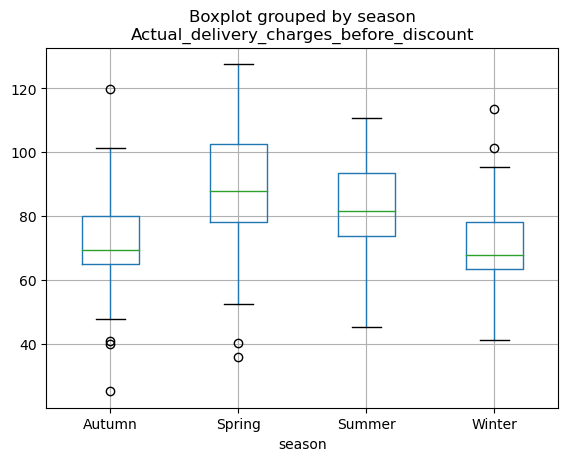

In [46]:
boxp = outlier_data_copy.boxplot(column='Actual_delivery_charges_before_discount', by = 'season')

We will use the 4 linear models created in the missing data section to predict delivery charges for outlier_data_copy and find out residuals..

In [47]:
# taking care of required boolean columns 
outlier_data_copy['is_expedited_delivery'] = outlier_data_copy['is_expedited_delivery'].astype('int')
outlier_data_copy['is_happy_customer'] = outlier_data_copy['is_happy_customer'].astype('int')

In [48]:
# creating 4 dataframes according to season with independent features for the model prediction
summer_outlier_data = outlier_data_copy.loc[outlier_data_copy['season']== 'Summer', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
winter_outlier_data = outlier_data_copy.loc[outlier_data_copy['season']== 'Winter', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
autumn_outlier_data = outlier_data_copy.loc[outlier_data_copy['season']== 'Autumn', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
spring_outlier_data = outlier_data_copy.loc[outlier_data_copy['season']== 'Spring', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]


In [49]:
# predicting delivery charges(before discount) for different seasons using the 4 models introduced in missing data.
summer_outlier_pred = summer_model.predict(summer_outlier_data)
winter_outlier_pred = winter_model.predict(winter_outlier_data)
autumn_outlier_pred = autumn_model.predict(autumn_outlier_data)
spring_outlier_pred = spring_model.predict(spring_outlier_data)


In [50]:
# creating a new column in outlier_data_copy for the predicted delivery charges (before discount)
outlier_data_copy.loc[outlier_data_copy['season']== 'Summer', 'predicted_delivery_charge_before_discount'] = list(summer_outlier_pred)
outlier_data_copy.loc[outlier_data_copy['season']== 'Winter', 'predicted_delivery_charge_before_discount'] = list(winter_outlier_pred)
outlier_data_copy.loc[outlier_data_copy['season']== 'Autumn', 'predicted_delivery_charge_before_discount'] = list(autumn_outlier_pred)
outlier_data_copy.loc[outlier_data_copy['season']== 'Spring', 'predicted_delivery_charge_before_discount'] = list(spring_outlier_pred)


In [51]:
outlier_data_copy.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,Actual_delivery_charges_before_discount,predicted_delivery_charge_before_discount
0,ORD041775,ID6167417939,2022-11-25,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,86.081,-37.815047,144.960160,0,Spring,1,0.91546,will not stay on the phone frequently powers o...,0,86.081000,76.466468
1,ORD260731,ID5301568579,2022-03-05,Thompson,"[('Toshika 750', 2), ('Olivia x460', 2), ('Uni...",20450,65.126,-37.808675,144.942337,0,Autumn,0,0.60933,four stars i love it,1,65.126000,69.870756
2,ORD483772,ID2400289305,2022-10-25,Bakers,"[('pearTV', 1), ('Alcon 10', 1)]",15260,79.578,-37.805594,144.983530,0,Spring,0,1.13994,very nice! everything is working fine. just ha...,1,79.578000,97.114306
3,ORD025148,ID3367904406,2022-09-06,Nickolson,"[('iAssist Line', 2), ('Thunder line', 2), ('T...",31030,44.965,-37.812933,144.968077,25,Spring,0,0.64350,waste of money this is not unlocked.. bought t...,0,59.953333,64.305061
4,ORD329595,ID1879216504,2022-06-12,Thompson,"[('Toshika 750', 2), ('Universe Note', 1)]",12090,72.967,-37.799616,144.963654,0,Winter,0,2.05922,try everything good,1,72.967000,88.535146


In [52]:
# Now we will calculate residual values for delivery charges
outlier_data_copy['residuals'] = outlier_data_copy['Actual_delivery_charges_before_discount']- outlier_data_copy['predicted_delivery_charge_before_discount']
outlier_data_copy.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,Actual_delivery_charges_before_discount,predicted_delivery_charge_before_discount,residuals
0,ORD041775,ID6167417939,2022-11-25,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,86.081,-37.815047,144.960160,0,Spring,1,0.91546,will not stay on the phone frequently powers o...,0,86.081000,76.466468,9.614532
1,ORD260731,ID5301568579,2022-03-05,Thompson,"[('Toshika 750', 2), ('Olivia x460', 2), ('Uni...",20450,65.126,-37.808675,144.942337,0,Autumn,0,0.60933,four stars i love it,1,65.126000,69.870756,-4.744756
2,ORD483772,ID2400289305,2022-10-25,Bakers,"[('pearTV', 1), ('Alcon 10', 1)]",15260,79.578,-37.805594,144.983530,0,Spring,0,1.13994,very nice! everything is working fine. just ha...,1,79.578000,97.114306,-17.536306
3,ORD025148,ID3367904406,2022-09-06,Nickolson,"[('iAssist Line', 2), ('Thunder line', 2), ('T...",31030,44.965,-37.812933,144.968077,25,Spring,0,0.64350,waste of money this is not unlocked.. bought t...,0,59.953333,64.305061,-4.351728
4,ORD329595,ID1879216504,2022-06-12,Thompson,"[('Toshika 750', 2), ('Universe Note', 1)]",12090,72.967,-37.799616,144.963654,0,Winter,0,2.05922,try everything good,1,72.967000,88.535146,-15.568146


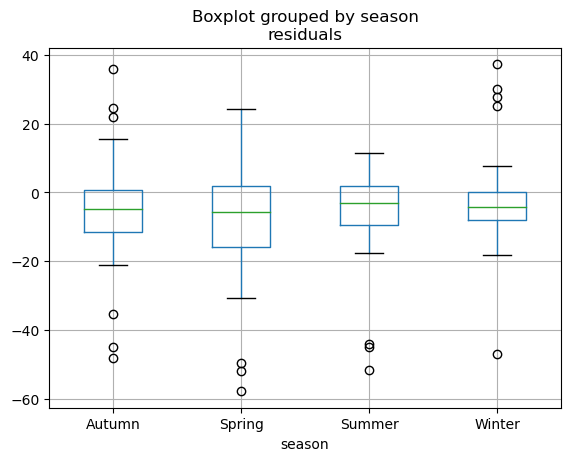

In [53]:
boxp2 = outlier_data_copy.boxplot(column='residuals', by = 'season')

We can observe from the above that the number of residuals increased from our last approach. We will remove these entries.   
To calculate these outlier entries, we would need to find the Inner Quartile range of the residual values for different seasons, and find a range of expected residuals, anything that does not belong to that range will be an outlier.   
Range will be [Q1- 1.5(IQR), Q3+1.5(IQR)]

In [54]:
# gathering seasonal data with residuals
summer_pred = outlier_data_copy[outlier_data_copy['season'] == 'Summer'] 
winter_pred = outlier_data_copy[outlier_data_copy['season'] == 'Winter'] 
autumn_pred = outlier_data_copy[outlier_data_copy['season'] == 'Autumn'] 
spring_pred = outlier_data_copy[outlier_data_copy['season'] == 'Spring'] 

In [55]:
def fence_threshold (column):
    '''
       This function delivers upper and lower fence for 
       some data by calculating IQR and whiskers.

       Input Parameter:
           column: column of a pandas dataframe

       Output:
           lower_fence: lower acceptable limit 
           uper_fence: upper acceptable limit
 
   ''' 
    # getting first quantile
    q1 = column.quantile(q=.25)
    # getting third quantile
    q3= column.quantile(q=.75)
    # calculating iqr
    iqr = q3-q1
    # calculating fences
    lower_fence = q1 - (1.5*iqr)
    upper_fence = q3 + (1.5*iqr)
    
    print('Any residual value more than', upper_fence, "or less than", lower_fence, "will be considered an outlier.")
    return lower_fence, upper_fence

In [56]:
# calculating threshold to be an outlier - summer 
summer_lower_fence, summer_upper_fence = fence_threshold(summer_pred['residuals'])

Any residual value more than 19.17496795307211 or less than -26.63095145597717 will be considered an outlier.


In [57]:
# calculating threshold to be an outlier - winter
winter_lower_fence, winter_upper_fence = fence_threshold(winter_pred['residuals'])

Any residual value more than 12.44584062434978 or less than -20.433634249360374 will be considered an outlier.


In [58]:
# calculating threshold to be an outlier - autumn
autumn_lower_fence, autumn_upper_fence = fence_threshold(autumn_pred['residuals'])

Any residual value more than 19.40201089804495 or less than -30.159951881222902 will be considered an outlier.


In [59]:
# calculating threshold to be an outlier - spring
spring_lower_fence, spring_upper_fence = fence_threshold(spring_pred['residuals'])

Any residual value more than 28.40021636096366 or less than -42.21383203596296 will be considered an outlier.


In [60]:
# now we will find out these outlier values
summer_pred['outlier'] = summer_pred['residuals'].apply(lambda x: True if x>summer_upper_fence or x<summer_lower_fence else False )
winter_pred['outlier'] = winter_pred['residuals'].apply(lambda x: True if x>winter_upper_fence or x<winter_lower_fence else False )
autumn_pred['outlier'] = autumn_pred['residuals'].apply(lambda x: True if x>autumn_upper_fence or x<autumn_lower_fence else False )
spring_pred['outlier'] = spring_pred['residuals'].apply(lambda x: True if x>spring_upper_fence or x<spring_lower_fence else False )

In [61]:
outlier_data_copy.loc[outlier_data_copy['season']== 'Summer', 'outlier'] = summer_pred['outlier']
outlier_data_copy.loc[outlier_data_copy['season']== 'Winter', 'outlier'] = winter_pred['outlier']
outlier_data_copy.loc[outlier_data_copy['season']== 'Autumn', 'outlier'] = autumn_pred['outlier']
outlier_data_copy.loc[outlier_data_copy['season']== 'Spring', 'outlier'] = spring_pred['outlier']


In [62]:
len(outlier_data_copy[outlier_data_copy['outlier'] == True])

17

There are 17 outliers in our data!

In [63]:
# Now we will remove these outliers from the actual outlier data 
outlier_data.loc[:,'outlier'] = outlier_data_copy['outlier']
outlier_data = outlier_data.loc[outlier_data["outlier"] == False ]

In [64]:
outlier_data.drop("outlier", axis=1, inplace = True)
outlier_data.shape

(483, 15)

In [65]:
outlier_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD041775,ID6167417939,2022-11-25,Nickolson,"[('Candle Inferno', 1), ('Universe Note', 1)]",3880,86.081,-37.815047,144.960160,0,Spring,True,0.91546,will not stay on the phone frequently powers o...,False
1,ORD260731,ID5301568579,2022-03-05,Thompson,"[('Toshika 750', 2), ('Olivia x460', 2), ('Uni...",20450,65.126,-37.808675,144.942337,0,Autumn,False,0.60933,four stars i love it,True
2,ORD483772,ID2400289305,2022-10-25,Bakers,"[('pearTV', 1), ('Alcon 10', 1)]",15260,79.578,-37.805594,144.983530,0,Spring,False,1.13994,very nice! everything is working fine. just ha...,True
3,ORD025148,ID3367904406,2022-09-06,Nickolson,"[('iAssist Line', 2), ('Thunder line', 2), ('T...",31030,44.965,-37.812933,144.968077,25,Spring,False,0.64350,waste of money this is not unlocked.. bought t...,False
4,ORD329595,ID1879216504,2022-06-12,Thompson,"[('Toshika 750', 2), ('Universe Note', 1)]",12090,72.967,-37.799616,144.963654,0,Winter,False,2.05922,try everything good,True


In [66]:
# export to csv
outlier_data.to_csv("./32776705_outlier_data_solution.csv")

<div class="alert alert-block alert-success">
    
## 5.  Dirty Data  <a class="anchor" name="dirty"></a>

In [67]:
# loading dirty data files
dirty_data = pd.read_csv("./32776705_dirty_data.csv")
dirty_data.shape

(500, 15)

dirty_data datframe has 500 records and 15 columns. That means we have 500 orders to tackle..  
Before digging into cleaning the data, we will create a new column, to counter the changes made in each row. Since every row can only have 0 or 1 error, its important for us to keep a track of all the changes made!

In [68]:
dirty_data['counter'] = 0
dirty_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter
0,ORD253098,ID5402876198,2022-04-16,Nickolson,"[('Alcon 10', 1), ('Lucent 330S', 1)]",10180,64.923,-37.820339,144.977384,0,Autumn,False,0.71561,five stars exactly as promised.,True,0
1,ORD203248,ID2489014343,2022-01-31,Bakers,"[('Alcon 10', 2), ('Toshika 750', 1)]",22220,78.700,-37.798490,144.977975,25,Summer,True,1.98599,"great phone for me, this was the best phone. t...",True,0
2,ORD125848,ID1542137496,2022-09-19,Nickolson,"[('Candle Inferno', 1), ('Olivia x460', 1)]",1655,85.577,-37.814861,144.962550,0,Spring,True,0.74286,one star bought as new but received a refurbed...,False,0
3,ORD465604,ID2384091383,2022-02-09,Nickolson,"[('Olivia x460', 1), ('pearTV', 2), ('iStream'...",16370,47.208,-37.807935,144.973029,25,Summer,False,1.22539,the earlier models were so simple to use. no n...,False,0
4,ORD160311,ID5232347245,2022-11-26,Thompson,"[('Candle Inferno', 2), ('Toshika 750', 1), ('...",17800,97.776,-37.811732,144.948340,0,Spring,True,0.15321,NaN,True,0


Lets look at the date column, we can see record 498 shows date 2022-25-12,since our dates should be in YYYY-MM-DD format, 25 as a month number doesnt make sense. Lets rectify this!

<div class="alert alert-block alert-warning">
    
### 5.1. Date Handling <a class="anchor" name="date"></a>

In [69]:
# creating a new datframe
date_handle = pd.DataFrame(dirty_data['date'])
date_handle['correct_format'] = pd.to_datetime(date_handle['date'], errors='coerce',format = "%Y-%m-%d")
date_handle

,date,correct_format
0,2022-04-16,2022-04-16
1,2022-01-31,2022-01-31
2,2022-09-19,2022-09-19
3,2022-02-09,2022-02-09
4,2022-11-26,2022-11-26
...,...,...
495,2022-03-05,2022-03-05
496,2022-06-19,2022-06-19
497,2022-06-22,2022-06-22
498,2022-25-12,NaT


In [70]:
# extracting null values -> records that dont match given format
filter = date_handle['correct_format'].isnull() == True
invalid_dates = date_handle[filter]
invalid_dates

,date,correct_format
87,2022-16-03,NaT
186,2022-Sep-08,NaT
216,2022-17-09,NaT
245,Tue Jul 12 00:00:00 2022,NaT
348,2022-18-08,NaT
472,2022-23-09,NaT
485,Wed Oct 12 00:00:00 2022,NaT
489,2022-16-06,NaT
498,2022-25-12,NaT


Now, we can see that there are 3 different formats other than the one requried!   
We created a new dataframe invalid_dates, for dates in the wong format. In the following steps we will correct their format and change the counter values. 

In [71]:
def extract_date(df, date_format):
    '''
    This functions takes in a datframe and changes the values in date column to %Y-%m-%d format
        Input parameters: 
            df: A pandas Dataframe
            date_format: format in which the dates are in the 
            given df.

        Outputs:
            A dataframe with 2 columns, both have different date formats.
    
    '''
    
    # creating a temporary dataframe to make changes
    temp_df = df.copy()
    temp_df['correct_format'] = pd.to_datetime(temp_df['date'], errors='coerce',format = date_format)
    filter = temp_df['correct_format'].isnull() == False
    #strftime o/ps a string- changing the format for the dates 
    temp_df['correct_format'] = pd.to_datetime(temp_df['date'], errors='coerce', format=date_format).dt.strftime("%Y-%m-%d")

    return temp_df[filter]
            


In [72]:
wrong_format1 = extract_date(invalid_dates,"%Y-%d-%m" )
wrong_format1

,date,correct_format
87,2022-16-03,2022-03-16
216,2022-17-09,2022-09-17
348,2022-18-08,2022-08-18
472,2022-23-09,2022-09-23
489,2022-16-06,2022-06-16
498,2022-25-12,2022-12-25


In [73]:
# getting the index of wrongly formatted dates
wrong_format1_idx= list(wrong_format1.index)
wrong_format1_idx

[87, 216, 348, 472, 489, 498]

In [74]:
wrong_format2 = extract_date(invalid_dates,'%c')
wrong_format2

,date,correct_format
245,Tue Jul 12 00:00:00 2022,2022-07-12
485,Wed Oct 12 00:00:00 2022,2022-10-12


In [75]:
# getting the index of wrongly formatted dates
wrong_format2_idx = list(wrong_format2.index)
wrong_format2_idx

[245, 485]

In [76]:
wrong_format3 = extract_date(invalid_dates,"%Y-%b-%d")
wrong_format3

,date,correct_format
186,2022-Sep-08,2022-09-08


In [77]:
# getting the index of wrongly formatted dates
wrong_format3_idx = list(wrong_format3.index)
wrong_format3_idx

[186]

In [78]:
dirty_data.loc[485, 'date']

'Wed Oct 12 00:00:00 2022'

In [79]:
def correcting_dates(actual_df, ref_df, idx_list):
    '''
    Input Parameter:
        actual_df: A pandas Dataframe (with date, counter columns)
        ref_df: A Pandas Dataframe
        idx_list: A python list
        
    output:
        Returns a Pandas dataframe with updates date and counter column.
    '''
    # actual_df should have date and counter column 
    # REF DFSHOULD have correct format column 
    
    for idx in idx_list:
        actual_df.loc[idx, 'date'] = ref_df.loc[idx, 'correct_format']
        actual_df.loc[idx, 'counter'] += 1
        
    return actual_df

In [80]:
dirty_data2 = correcting_dates(dirty_data, wrong_format1, wrong_format1_idx)
dirty_data3 = correcting_dates(dirty_data2, wrong_format2, wrong_format2_idx)
dirty_data_dates = correcting_dates(dirty_data3, wrong_format3, wrong_format3_idx)

We can see an example, following is a date in its original format: 

<div>
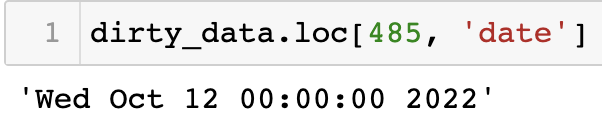
</div>



Date has been changed to the right format :
<div>
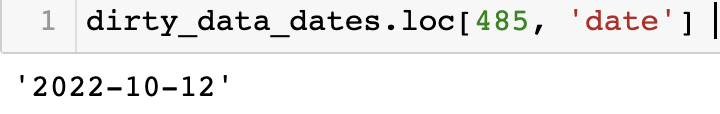
</div>


In [81]:
# We made changes in 9 rows 
dirty_data_dates['counter'].value_counts()

0    491
1      9
Name: counter, dtype: int64

In [82]:
# changing names, for the ease of coding
dirty_data = dirty_data_dates

<div class="alert alert-block alert-warning">
    
### 5.2. Seasons <a class="anchor" name="season"></a>

We Know that their are 4 seasons in Nature, Summer, Autumn, Winter and Spring.. We will check if their is any anomalous season in our data..

In [83]:
dirty_copy = dirty_data.copy()
dirty_data['season'].value_counts()

Autumn    133
Winter    127
Summer    120
Spring    113
winter      4
summer      2
spring      1
Name: season, dtype: int64

From above we can see that their are 4 seasons, just in different casing. We will be capitalizing all the season entries to maintain consitency.

In [84]:
dirty_data['season'] = dirty_data['season'].apply(lambda x : x.capitalize())
dirty_data['season'].value_counts()

Autumn    133
Winter    131
Summer    122
Spring    114
Name: season, dtype: int64

From above we can see that season column has been recitified, lets change the counter column to refelct these changes...

In [85]:
# getting index for dirty season records
idx_list_season = [idx for idx, i in enumerate(dirty_copy['season']) if i not in list(dirty_data['season'])]
idx_list_season

[19, 41, 155, 240, 246, 260, 359]

In [86]:
# changing counter
for idx in idx_list_season:
    dirty_data.loc[idx, 'counter'] += 1

In [87]:
dirty_data['counter'].value_counts()

0    484
1     16
Name: counter, dtype: int64

From the above we can assure that we have rectified 16 records.

<div class="alert alert-block alert-warning">
    
### 5.3. Customer Location <a class="anchor" name="cust_loc"></a>

In [88]:
# creating another dataframe for resolving latitude, longitude issue.
loc_df = dirty_data.copy()

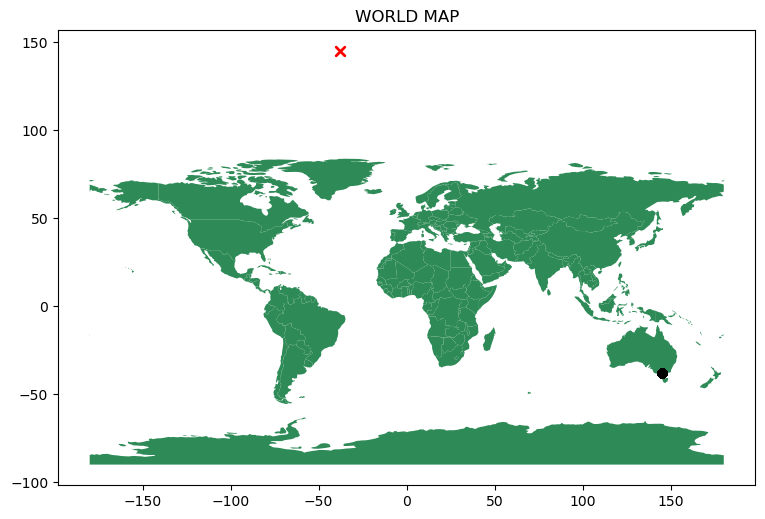

In [89]:
# Reading world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating a new Datafrme which only contains Australia
australia = world[world.name == 'Australia']

# .values[0] notation is used to extract this geometry object from the pandas Series object.
australia_boundary = australia.geometry.values[0]

# Creating a dataframe from customater geolocations 
df_geo = gpd.GeoDataFrame(loc_df, geometry = gpd.points_from_xy(loc_df.customer_long,loc_df.customer_lat))

# creating a dataframe with customer locations outside Australia 
outside_australia = ~df_geo.within(australia_boundary)


# Plotting world map
ax = world.plot(color='seagreen')
df_geo[~outside_australia].plot(ax=ax, color='black')  # Plot only the points within Australia
df_geo[outside_australia].plot(ax=ax, color='red', marker='x', markersize=50)  # Plot the points outside Australia

# Setting the title, figure size
plt.title('WORLD MAP')
fig = plt.gcf()
fig.set_size_inches(9, 7)

# Show the plot
plt.show()


From the above plot we can see that there is some anomalies in Customer location as this business only caters to people living in Australia.

In [90]:
df_outside_australia = df_geo[outside_australia].reset_index(drop=True)
df_outside_australia # cust_lat and cust_long have been swapped 

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter,geometry
0,ORD355238,ID0634775866,2022-05-07,Thompson,"[('Toshika 750', 1), ('Universe Note', 1)]",7770,32.814,144.936670,-37.815178,50,Autumn,False,0.95605,four stars great case fit great,True,0,POINT (-37.815 144.937)
1,ORD079892,ID3810637325,2022-09-18,Thompson,"[('Candle Inferno', 2), ('Olivia x460', 2), ('...",14570,78.055,144.942801,-37.820957,25,Spring,True,0.99562,five stars work perfectly in costa rica,True,0,POINT (-37.821 144.943)
2,ORD070678,ID6167441056,2022-03-01,Nickolson,"[('pearTV', 2), ('iAssist Line', 2), ('Olivia ...",19820,58.803,144.962828,-37.813177,25,Autumn,True,0.84458,five stars satisfied love the phone speedy del...,True,0,POINT (-37.813 144.963)
3,ORD205936,ID0579391888,2022-06-14,Nickolson,"[('Universe Note', 1), ('iStream', 2), ('pearT...",17595,32.225,144.956248,-37.821683,50,Winter,True,1.21924,disappointed was damaged,False,0,POINT (-37.822 144.956)
4,ORD060197,ID0247417666,2022-03-25,Nickolson,"[('Universe Note', 2), ('Candle Inferno', 2), ...",22840,58.290,144.969054,-37.817748,25,Autumn,True,0.10388,five stars was a really good phone,True,0,POINT (-37.818 144.969)


In [91]:
# list of order ids for incorrect locations
order_ids = df_outside_australia['order_id']
order_ids

0    ORD355238
1    ORD079892
2    ORD070678
3    ORD205936
4    ORD060197
Name: order_id, dtype: object

In [92]:
dirty_data[dirty_data['order_id'] == 'ORD079892']

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter
99,ORD079892,ID3810637325,2022-09-18,Thompson,"[('Candle Inferno', 2), ('Olivia x460', 2), ('...",14570,78.055,144.942801,-37.820957,25,Spring,True,0.99562,five stars work perfectly in costa rica,True,0


In [93]:
# looping over order ids with incorrect customer location
for i in order_ids:
    # increasing counter 
    dirty_data.loc[dirty_data['order_id'] == i, 'counter'] += 1 
    
    # saving temporary values
    actual_longitude = dirty_data.loc[dirty_data['order_id'] == i, 'customer_lat']
    actual_latitude = dirty_data.loc[dirty_data['order_id'] == i, 'customer_long']

    # replacing values 
    dirty_data.loc[dirty_data['order_id'] == i, 'customer_lat'] = actual_latitude 
    dirty_data.loc[dirty_data['order_id'] == i, 'customer_long'] = actual_longitude 

Before correcting location, an order had the following customer location:  

<div>
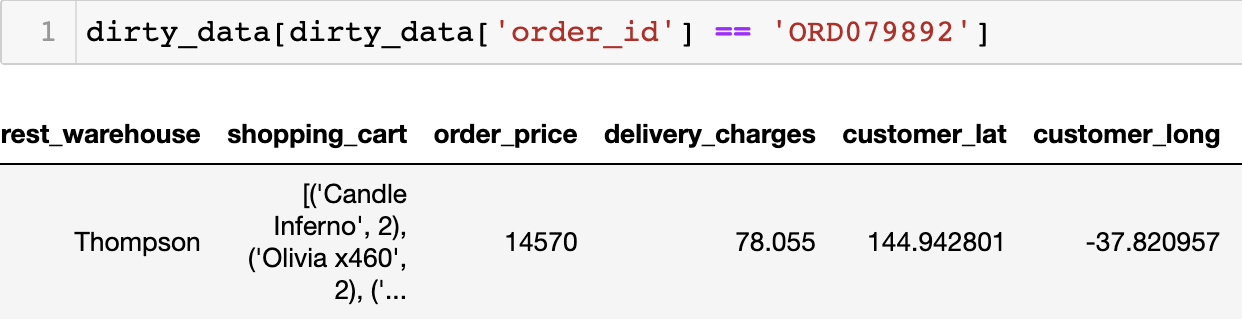
</div>



After correcting the location:  


<div>
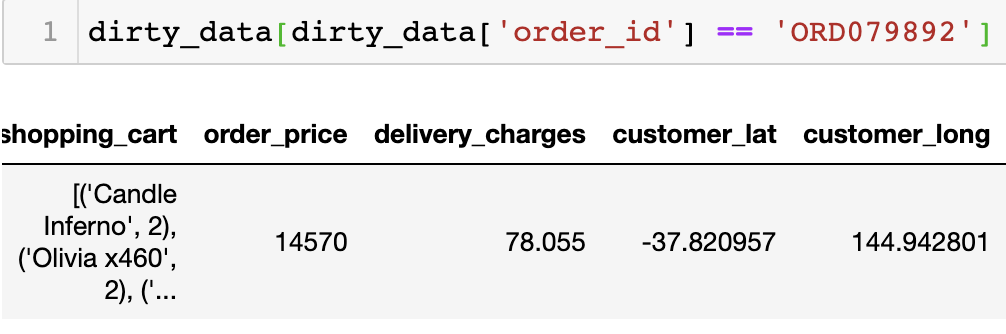
</div>



In [94]:
dirty_data['counter'].value_counts()

0    479
1     21
Name: counter, dtype: int64

We have corrected 21 records till now.

<div class="alert alert-block alert-warning">
    
### 5.4. Warehouses <a class="anchor" name="ware"></a>

Here, we will be correcting 2 columns:
* distance_to_nearest_warehouse
* nearest_warehouse	


In [95]:
# opening warehouse csv to get unique warehouse names
warehouses = pd.read_csv("./warehouses.csv")
warehouses

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [96]:
# creating a copy of our main dataframe to make changes
distance_df = dirty_data.copy()

In [97]:
# creating a function to get distance between 2 points

def nearest_distance(lat1, lon1, lat2, lon2):
    
    '''
    Function to calculate the nearest distance between 2 points based on their latitudes and longitudes.
    Here, radius of Earth is assumed to be 6378 kms.
    
        Input Parameters:
            lat1: latitude value
            lon1: longitude value
            lat2: latitude value 
            lon2: longitude value
    
        Output:
            Distance between 2 points.
    '''
    
    # radius in Kms
    radius = 6378 

    #converting customer latitudes and longitudes to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
   
    # calculating differences between latitudes and longitudes  
    lat_diff = lat2- lat1
    lon_diff = lon2 - lon1 
    
   # applying Haversine formula to calculate nearest distance
    a = sin(lat_diff / 2)**2 + cos(lat1) * cos(lat2) * sin(lon_diff / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = round(radius * c, 5)
    
    return distance

In [98]:
# list of customer locations as a tuple
customer_locs = list(zip(distance_df['customer_lat'], distance_df['customer_long']))
len(customer_locs)

500

In [99]:
# creating 2 lists for storing actual nearest warehouse distance and nearest warehouse
warehouse_distance = []
correct_closest_warehouse = []


for cust_lat, cust_lon in customer_locs:
    min_dist = float('inf') # setting min distance to be the max known value
    closest_warehouse = None
    # iterating over every row of warehouses df
    for idx, row in warehouses.iterrows():
        dist = nearest_distance(cust_lat, cust_lon, row['lat'], row['lon'])
        if dist < min_dist:
            min_dist = dist
            closest_warehouse = row['names']
    warehouse_distance.append(min_dist)
    correct_closest_warehouse.append(closest_warehouse)
    

In [100]:
# adding 2 columns to df
distance_df['actual_distance'] = warehouse_distance
distance_df['actual_warehouse'] = correct_closest_warehouse
distance_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter,actual_distance,actual_warehouse
0,ORD253098,ID5402876198,2022-04-16,Nickolson,"[('Alcon 10', 1), ('Lucent 330S', 1)]",10180,64.923,-37.820339,144.977384,0,Autumn,False,0.71561,five stars exactly as promised.,True,0,0.71561,Nickolson
1,ORD203248,ID2489014343,2022-01-31,Bakers,"[('Alcon 10', 2), ('Toshika 750', 1)]",22220,78.700,-37.798490,144.977975,25,Summer,True,1.98599,"great phone for me, this was the best phone. t...",True,0,1.98599,Bakers
2,ORD125848,ID1542137496,2022-09-19,Nickolson,"[('Candle Inferno', 1), ('Olivia x460', 1)]",1655,85.577,-37.814861,144.962550,0,Spring,True,0.74286,one star bought as new but received a refurbed...,False,0,0.74286,Nickolson
3,ORD465604,ID2384091383,2022-02-09,Nickolson,"[('Olivia x460', 1), ('pearTV', 2), ('iStream'...",16370,47.208,-37.807935,144.973029,25,Summer,False,1.22539,the earlier models were so simple to use. no n...,False,0,1.22539,Nickolson
4,ORD160311,ID5232347245,2022-11-26,Thompson,"[('Candle Inferno', 2), ('Toshika 750', 1), ('...",17800,97.776,-37.811732,144.948340,0,Spring,True,0.15321,NaN,True,0,0.15321,Thompson


In [101]:
# incorrect arc dist
incorrect_dist = distance_df.loc[distance_df['distance_to_nearest_warehouse'] != distance_df['actual_distance'], 'order_id']
len(incorrect_dist)

7

We can notice that there are 7 records with incorrect warehouse distance. We are correcting the same in the following step:

In [102]:
# changing values in dirty_data
for order in incorrect_dist:
    # increasing counter 
    dirty_data.loc[dirty_data['order_id'] == order, 'counter'] += 1
    # changing nearest_distance value
    dirty_data.loc[dirty_data['order_id'] == order, 'distance_to_nearest_warehouse'] = distance_df.loc[distance_df['order_id'] == order, 'actual_distance']   

In [103]:
dirty_data['counter'].value_counts()

0    472
1     28
Name: counter, dtype: int64

We have corrected 28 records till now.

In [104]:
#incorrect warehouses
incorrect_warehouses = distance_df.loc[distance_df['nearest_warehouse'] != distance_df['actual_warehouse'], 'order_id']
len(incorrect_warehouses)

10

Again, we can see that 10 records contain the incorrect warehouse name, which we will correct in the next phase.

In [105]:
# changing values dirty_data
for order in incorrect_warehouses:
    # increasing counter 
    dirty_data.loc[dirty_data['order_id'] == order, 'counter'] += 1
    # changing nearest_distance value
    dirty_data.loc[dirty_data['order_id'] == order, 'nearest_warehouse'] = distance_df.loc[distance_df['order_id'] == order, 'actual_warehouse']
    

In [106]:
dirty_data['counter'].value_counts()

0    462
1     38
Name: counter, dtype: int64

We successfully corrected 38 order records. 

<div class="alert alert-block alert-warning">
    
### 5.5. Shopping Cart <a class="anchor" name="shop"></a>

In [107]:
shopping_cart = dirty_data['shopping_cart']
shopping_cart

0                  [('Alcon 10', 1), ('Lucent 330S', 1)]
1                  [('Alcon 10', 2), ('Toshika 750', 1)]
2            [('Candle Inferno', 1), ('Olivia x460', 1)]
3      [('Olivia x460', 1), ('pearTV', 2), ('iStream'...
4      [('Candle Inferno', 2), ('Toshika 750', 1), ('...
                             ...                        
495             [('Candle Inferno', 1), ('Alcon 10', 2)]
496    [('Universe Note', 1), ('iAssist Line', 2), ('...
497    [('Lucent 330S', 2), ('Candle Inferno', 1), ('...
498    [('iStream', 2), ('Olivia x460', 1), ('iAssist...
499    [('Toshika 750', 2), ('iAssist Line', 1), ('Al...
Name: shopping_cart, Length: 500, dtype: object

In [108]:
items =[tups[0] for i in shopping_cart for tups in eval(i) ] # eval(i ) because i was a string list 
set(items)

{'Alcon 10',
 'Candle Inferno',
 'Lucent 330S',
 'Olivia x460',
 'Thunder line',
 'Toshika 750',
 'Universe Note',
 'iAssist Line',
 'iStream',
 'pearTV'}

We verified that there are only 10 branded items 

<div class="alert alert-block alert-warning">
    
### 5.6. Order Price <a class="anchor" name="op"></a>

To check order price column, we need to know individial item cost. We can calculate that from the records that have already been altered ( since there is only 1 error in any record). Those records must be error free, which makes it easy for us to use them for this calculation process. 

In [109]:
# creating a dataframe with counter =1 as these rows are now error free. 
op_df = dirty_data[dirty_data['counter']==1]
len(op_df)

38

We have 38 error free records till now.

In [110]:
# getting unique items, did list again as sets are unordered.
items = list(set(items))
items

['pearTV',
 'iStream',
 'Thunder line',
 'Lucent 330S',
 'Universe Note',
 'iAssist Line',
 'Alcon 10',
 'Candle Inferno',
 'Olivia x460',
 'Toshika 750']

In [111]:
# converting list of tuples(from shopping cart) into a list of dictionaries
order_dicts = []
for i in op_df['shopping_cart']:
    order = {}
    for k,v in eval(i):
        order[k] = v
    order_dicts.append(order)   

In [112]:
order_dicts

[{'Toshika 750': 1, 'Universe Note': 1},
 {'Toshika 750': 2, 'iAssist Line': 2},
 {'iAssist Line': 1, 'Lucent 330S': 1, 'Candle Inferno': 2},
 {'pearTV': 1, 'Alcon 10': 2, 'Thunder line': 2},
 {'iAssist Line': 2, 'pearTV': 1},
 {'Candle Inferno': 2, 'iAssist Line': 2, 'Thunder line': 1, 'Alcon 10': 2},
 {'Universe Note': 1, 'Thunder line': 2},
 {'pearTV': 1, 'Olivia x460': 2, 'Universe Note': 1, 'Candle Inferno': 1},
 {'Candle Inferno': 2,
  'Olivia x460': 2,
  'Universe Note': 2,
  'Thunder line': 2},
 {'Toshika 750': 2, 'iStream': 2},
 {'pearTV': 2, 'iAssist Line': 2, 'Olivia x460': 2, 'iStream': 2},
 {'Thunder line': 1, 'Lucent 330S': 1, 'Toshika 750': 1, 'iAssist Line': 2},
 {'Lucent 330S': 2, 'pearTV': 1},
 {'Universe Note': 1, 'iStream': 2, 'pearTV': 2, 'Olivia x460': 1},
 {'iStream': 2, 'pearTV': 2, 'Universe Note': 1, 'Olivia x460': 1},
 {'Candle Inferno': 1, 'Toshika 750': 2, 'iStream': 2, 'Alcon 10': 1},
 {'Universe Note': 1, 'iStream': 1, 'Olivia x460': 2, 'Alcon 10': 1},
 {

In [113]:
# to save item quantites in a matrix 
quantity_matrix = []
for order in order_dicts:
    row = []
    for key in items:
        value = order.get(key, 0)
        row.append(value)
    quantity_matrix.append(row)

In [114]:
quantity_matrix # order of items is same as item list

[[0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 2, 0, 0, 0, 2],
 [0, 0, 0, 1, 0, 1, 0, 2, 0, 0],
 [1, 0, 2, 0, 0, 0, 2, 0, 0, 0],
 [1, 0, 0, 0, 0, 2, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 2, 2, 2, 0, 0],
 [0, 0, 2, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 1, 2, 0],
 [0, 0, 2, 0, 2, 0, 0, 2, 2, 0],
 [0, 2, 0, 0, 0, 0, 0, 0, 0, 2],
 [2, 2, 0, 0, 0, 2, 0, 0, 2, 0],
 [0, 0, 1, 1, 0, 2, 0, 0, 0, 1],
 [1, 0, 0, 2, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 0, 1, 0, 0, 0, 1, 0],
 [2, 2, 0, 0, 1, 0, 0, 0, 1, 0],
 [0, 2, 0, 0, 0, 0, 1, 1, 0, 2],
 [0, 1, 0, 0, 1, 0, 1, 0, 2, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 2],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 2],
 [0, 0, 0, 2, 2, 1, 0, 0, 0, 0],
 [2, 0, 1, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 2, 0, 0, 0],
 [0, 2, 1, 0, 0, 2, 2, 0, 0, 0],
 [1, 0, 0, 0, 0, 2, 1, 2, 0, 0],
 [2, 0, 0, 2, 2, 0, 0, 2, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 2, 0, 0, 2],
 [0, 0, 0, 0, 0, 2, 0, 2, 0, 0],
 [0, 2, 0, 0, 0, 2, 0, 0, 2, 1],
 [0, 0, 0, 1, 2, 0, 0, 0, 0, 2],
 [0, 2, 1,

In [115]:
np.shape(quantity_matrix) 

(38, 10)

We can see shape of our matrix is 38 * 10 as we have 38 correct orders and 10 items 

In [116]:
# now we will get order price array, head 10 since we have 10 columns 
order_price = op_df['order_price'].head(10)
order_price

17      7770
19     13090
41      4315
68     28570
71     10760
83     25390
87      7810
90     12640
99     14570
114     8940
Name: order_price, dtype: int64

In [117]:
variables = np.array(quantity_matrix[:10]) # took only 10 rows since variables should be a square matrix 
variables

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 2],
       [0, 0, 0, 1, 0, 1, 0, 2, 0, 0],
       [1, 0, 2, 0, 0, 0, 2, 0, 0, 0],
       [1, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 2, 2, 2, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 2, 0],
       [0, 0, 2, 0, 2, 0, 0, 2, 2, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 2]])

In [118]:
# solving for indiviadual item prices 
item_prices = np.linalg.solve(variables, order_price) 
item_prices = np.rint(item_prices) #rounding # the prices of items are in order of items list 

In [119]:
# a dictionary with items and their prices
price_dict= {}
price_dict = dict(zip(items, item_prices)) 
price_dict 

{'pearTV': 6310.0,
 'iStream': 150.0,
 'Thunder line': 2180.0,
 'Lucent 330S': 1230.0,
 'Universe Note': 3450.0,
 'iAssist Line': 2225.0,
 'Alcon 10': 8950.0,
 'Candle Inferno': 430.0,
 'Olivia x460': 1225.0,
 'Toshika 750': 4320.0}

In [120]:
# converting list of tuples into a list of dictionaries for all orders
all_order_dicts = []
for i in dirty_data_dates['shopping_cart']:
    order = {}
    for k,v in eval(i):
        order[k] = v
    all_order_dicts.append(order)   

In [121]:
len(all_order_dicts)

500

In [122]:
# Matrix for  all the records
error_matrix = []
for order in all_order_dicts :
    row = []
    for key in items:
        value = order.get(key, 0)
        row.append(value)
    error_matrix.append(row)

For matrix multiplication it's important that the number of columns in the first matrix must be equal to the number of rows in the second matrix. So, we will check for error_matrix and item_prices 

In [123]:
np.shape(error_matrix)

(500, 10)

In [124]:
np.shape(item_prices)

(10,)

In [125]:
# calcultaing the correct order prices
correct_order_price= np.dot(np.array(error_matrix), item_prices)
correct_order_price = list(correct_order_price)
correct_order_price 

[10180.0,
 22220.0,
 1655.0,
 16370.0,
 17800.0,
 4680.0,
 16500.0,
 4600.0,
 18050.0,
 10950.0,
 13390.0,
 6910.0,
 11875.0,
 8865.0,
 8770.0,
 7360.0,
 20275.0,
 7770.0,
 16915.0,
 13090.0,
 16280.0,
 13065.0,
 13590.0,
 9100.0,
 10930.0,
 7200.0,
 35030.0,
 4675.0,
 11500.0,
 13845.0,
 13240.0,
 2885.0,
 17070.0,
 6960.0,
 3410.0,
 7810.0,
 8135.0,
 14150.0,
 6900.0,
 19710.0,
 11855.0,
 4315.0,
 10940.0,
 6820.0,
 5180.0,
 21805.0,
 12720.0,
 1525.0,
 8790.0,
 13080.0,
 17410.0,
 28330.0,
 10945.0,
 11490.0,
 24050.0,
 12770.0,
 7200.0,
 14800.0,
 26540.0,
 4600.0,
 5545.0,
 10425.0,
 15940.0,
 32610.0,
 21585.0,
 14425.0,
 10765.0,
 5885.0,
 28570.0,
 10195.0,
 25350.0,
 10760.0,
 580.0,
 20380.0,
 15380.0,
 30990.0,
 10230.0,
 7770.0,
 26980.0,
 6060.0,
 6855.0,
 14615.0,
 10305.0,
 25390.0,
 19130.0,
 15970.0,
 16180.0,
 7810.0,
 18330.0,
 15070.0,
 12640.0,
 23095.0,
 9130.0,
 9140.0,
 26710.0,
 25530.0,
 17890.0,
 6900.0,
 15860.0,
 14570.0,
 14550.0,
 30210.0,
 11475.0,
 2135

In [126]:
# creating a new df for further changes
sub_df = dirty_data[['order_id', 'order_price']]
sub_df_copy = sub_df.copy() # to prevent any chained assignments
sub_df_copy.loc[:, 'correct_order_price'] = correct_order_price

In [127]:
# creating a list or orders with wronf order price
orders_wrong_op = []
for row in sub_df_copy.itertuples(index=False):
    if row.order_price == row.correct_order_price:
        continue
    else:
        orders_wrong_op.append(row.order_id)

In [128]:
len(orders_wrong_op)

13

In [129]:
# increasing counter for wrong records and changing their order price
for order in orders_wrong_op:
    # increasing counter 
    dirty_data.loc[dirty_data['order_id'] == order, 'counter'] += 1
    
    # changing orderprice value
    dirty_data.loc[dirty_data['order_id'] == order, 'order_price'] = sub_df_copy.loc[sub_df_copy['order_id'] == order, 'correct_order_price']
    
            

In [130]:
dirty_data['counter'].value_counts()

0    449
1     51
Name: counter, dtype: int64

<div class="alert alert-block alert-warning">
    
### 5.7. Happy Cutomer <a class="anchor" name="happy"></a>

In [131]:
# creating a new copy dataframe to make changes. 
data = dirty_data.copy()
data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter
0,ORD253098,ID5402876198,2022-04-16,Nickolson,"[('Alcon 10', 1), ('Lucent 330S', 1)]",10180,64.923,-37.820339,144.977384,0,Autumn,False,0.71561,five stars exactly as promised.,True,0
1,ORD203248,ID2489014343,2022-01-31,Bakers,"[('Alcon 10', 2), ('Toshika 750', 1)]",22220,78.700,-37.798490,144.977975,25,Summer,True,1.98599,"great phone for me, this was the best phone. t...",True,0
2,ORD125848,ID1542137496,2022-09-19,Nickolson,"[('Candle Inferno', 1), ('Olivia x460', 1)]",1655,85.577,-37.814861,144.962550,0,Spring,True,0.74286,one star bought as new but received a refurbed...,False,0
3,ORD465604,ID2384091383,2022-02-09,Nickolson,"[('Olivia x460', 1), ('pearTV', 2), ('iStream'...",16370,47.208,-37.807935,144.973029,25,Summer,False,1.22539,the earlier models were so simple to use. no n...,False,0
4,ORD160311,ID5232347245,2022-11-26,Thompson,"[('Candle Inferno', 2), ('Toshika 750', 1), ('...",17800,97.776,-37.811732,144.948340,0,Spring,True,0.15321,NaN,True,0


In [132]:
# instantiating SentimentIntensityAnalyzer class
sent_analyzer = SentimentIntensityAnalyzer()

In [133]:
# There is one empty value in the review column
len(data[data['latest_customer_review'].isna() == False])

499

In [134]:
# applying on not null records only
data['polarity_score'] = data['latest_customer_review'][data['latest_customer_review'].isna() == False].apply(lambda x : sent_analyzer.polarity_scores(x)['compound'])

In [135]:
# performing on non null records
data['accurate_happiness'] = data['polarity_score'][data['polarity_score'].isna() == False].apply(lambda x: True if x>= 0.05 else False)

In [136]:
# setting accurate happiness as True if there is no last review. 
data['accurate_happiness'].fillna(True, inplace=True)

In [137]:
# now we will check how many records were incorrect.
inaccurate_happiness = []
for row in data.itertuples(index=False):
    if row.is_happy_customer == row.accurate_happiness:
        continue
    else:
        inaccurate_happiness.append(row.order_id)

In [138]:
# list with order ids whose is_happy_customer column is inccorect
inaccurate_happiness

['ORD391373', 'ORD359721', 'ORD162878', 'ORD393704', 'ORD445915', 'ORD018618']

In [139]:
# changing values in the real df 
for order in inaccurate_happiness:
    # increasing counter 
    dirty_data.loc[dirty_data['order_id'] == order, 'counter'] += 1
    
    # changing orderprice value
    dirty_data.loc[dirty_data['order_id'] == order, 'is_happy_customer'] = data.loc[data['order_id'] == order, 'accurate_happiness']
    

In [140]:
dirty_data['counter'].value_counts()

0    443
1     57
Name: counter, dtype: int64

Till now we have rectified 57/500 records

<div class="alert alert-block alert-warning">
    
### 5.8. Expedited Delivery <a class="anchor" name="ex"></a>

To check whether the expedited delivery column is correct or not we will check whether our data has any outliers, by using the 4 linear models above, and will have a close look at the expedited column for these outliers.

In [141]:
# creating a copy of data to make changes
expedited_data = dirty_data.copy()

# handling boolean values
expedited_data['is_expedited_delivery'] = expedited_data['is_expedited_delivery'].astype('int')
expedited_data['is_happy_customer'] = expedited_data['is_happy_customer'].astype('int')

In [142]:
# creating 4 dataframes according to season with independent features for the model prediction
summer_expedited_data = expedited_data.loc[expedited_data['season']== 'Summer', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
winter_expedited_data = expedited_data.loc[expedited_data['season']== 'Winter', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
autumn_expedited_data = expedited_data.loc[expedited_data['season']== 'Autumn', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]
spring_expedited_data = expedited_data.loc[expedited_data['season']== 'Spring', ['is_expedited_delivery', 'is_happy_customer','distance_to_nearest_warehouse' ]]


In [143]:
# predicting delivery charges(before discount) for different seasons using the 4 models introduced in missing data.
summer_expedited_pred = summer_model.predict(summer_expedited_data)
winter_expedited_pred = winter_model.predict(winter_expedited_data)
autumn_expedited_pred = autumn_model.predict(autumn_expedited_data)
spring_expedited_pred = spring_model.predict(spring_expedited_data)

In [144]:
# creating a new column in expedited_data for the predicted delivery charges (before discount)
expedited_data.loc[expedited_data['season']== 'Summer', 'predicted_delivery_charge_before_discount'] = list(summer_expedited_pred)
expedited_data.loc[expedited_data['season']== 'Winter', 'predicted_delivery_charge_before_discount'] = list(winter_expedited_pred)
expedited_data.loc[expedited_data['season']== 'Autumn', 'predicted_delivery_charge_before_discount'] = list(autumn_expedited_pred)
expedited_data.loc[expedited_data['season']== 'Spring', 'predicted_delivery_charge_before_discount'] = list(spring_expedited_pred)


In [145]:
# now we will create a column for the actual delivery charges before APPLYING ANY DISCOUNT.
expedited_data.loc[:, 'Actual_delivery_charges_before_discount'] = expedited_data[['delivery_discount', 'delivery_charges']].apply(lambda x: x['delivery_charges'] / (1 - (x['delivery_discount']/100)), axis=1)


In [146]:
# Now we will calculate residual values for delivery charges
expedited_data['residuals'] = expedited_data['Actual_delivery_charges_before_discount']- expedited_data['predicted_delivery_charge_before_discount']
expedited_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter,predicted_delivery_charge_before_discount,Actual_delivery_charges_before_discount,residuals
0,ORD253098,ID5402876198,2022-04-16,Nickolson,"[('Alcon 10', 1), ('Lucent 330S', 1)]",10180,64.923,-37.820339,144.977384,0,Autumn,0,0.71561,five stars exactly as promised.,1,0,71.462280,64.923000,-6.539280
1,ORD203248,ID2489014343,2022-01-31,Bakers,"[('Alcon 10', 2), ('Toshika 750', 1)]",22220,78.700,-37.798490,144.977975,25,Summer,1,1.98599,"great phone for me, this was the best phone. t...",1,0,109.731614,104.933333,-4.798281
2,ORD125848,ID1542137496,2022-09-19,Nickolson,"[('Candle Inferno', 1), ('Olivia x460', 1)]",1655,85.577,-37.814861,144.962550,0,Spring,1,0.74286,one star bought as new but received a refurbed...,0,0,73.848676,85.577000,11.728324
3,ORD465604,ID2384091383,2022-02-09,Nickolson,"[('Olivia x460', 1), ('pearTV', 2), ('iStream'...",16370,47.208,-37.807935,144.973029,25,Summer,0,1.22539,the earlier models were so simple to use. no n...,0,0,68.499707,62.944000,-5.555707
4,ORD160311,ID5232347245,2022-11-26,Thompson,"[('Candle Inferno', 2), ('Toshika 750', 1), ('...",17800,97.776,-37.811732,144.948340,0,Spring,1,0.15321,NaN,1,0,90.185402,97.776000,7.590598


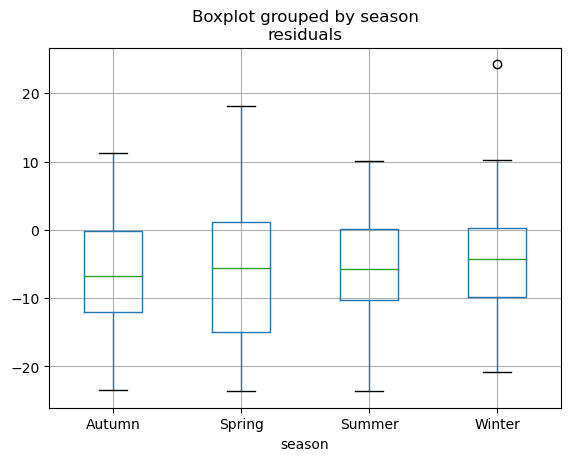

In [147]:
boxp3 = expedited_data.boxplot(column='residuals', by = 'season')

We can see there is only 1 outlier for winter season.

In [148]:
# gathering seasonal predicted data 
summer_pred_expedited = expedited_data[expedited_data['season'] == 'Summer'] 
winter_pred_expedited = expedited_data[expedited_data['season'] == 'Winter'] 
autumn_pred_expedited = expedited_data[expedited_data['season'] == 'Autumn'] 
spring_pred_expedited = expedited_data[expedited_data['season'] == 'Spring'] 

In [149]:
# calculating upper and lower fences from the fence_threshold function introduced above
summerex_lower_fence, summerex_upper_fence = fence_threshold(summer_pred_expedited['residuals'])

Any residual value more than 15.75566542399423 or less than -25.93462367607566 will be considered an outlier.


In [150]:
#calculating threshold to be an outlier - winter
winterex_lower_fence, winterex_upper_fence = fence_threshold(winter_pred_expedited['residuals'])

Any residual value more than 15.548928367117373 or less than -25.10606351533239 will be considered an outlier.


In [151]:
# calculating threshold to be an outlier - autumn
autumnex_lower_fence, autumnex_upper_fence = fence_threshold(autumn_pred_expedited['residuals'])

Any residual value more than 17.54330019738901 or less than -29.665867501214485 will be considered an outlier.


In [152]:
# calculating threshold to be an outlier - spring
springex_lower_fence, springex_upper_fence = fence_threshold(spring_pred_expedited['residuals'])

Any residual value more than 25.40218386314729 or less than -39.21234964329992 will be considered an outlier.


In [153]:
# now we will find out these outlier values 
summer_pred_expedited['outlier'] = summer_pred_expedited['residuals'].apply(lambda x: True if x>summerex_upper_fence or x<summerex_lower_fence else False )
winter_pred_expedited['outlier'] = winter_pred_expedited['residuals'].apply(lambda x: True if x>winterex_upper_fence or x<winterex_lower_fence else False )
autumn_pred_expedited['outlier'] = autumn_pred_expedited['residuals'].apply(lambda x: True if x>autumnex_upper_fence or x<autumnex_lower_fence else False )
spring_pred_expedited['outlier'] = spring_pred_expedited['residuals'].apply(lambda x: True if x>springex_upper_fence or x<springex_lower_fence else False )


In [154]:
# getting outlier column
expedited_data.loc[expedited_data['season']== 'Summer', 'outlier'] = summer_pred_expedited['outlier']
expedited_data.loc[expedited_data['season']== 'Winter', 'outlier'] = winter_pred_expedited['outlier']
expedited_data.loc[expedited_data['season']== 'Autumn', 'outlier'] = autumn_pred_expedited['outlier']
expedited_data.loc[expedited_data['season']== 'Spring', 'outlier'] = spring_pred_expedited['outlier']

In [155]:
expedited_data[expedited_data['outlier'] == True]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,delivery_discount,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,counter,predicted_delivery_charge_before_discount,Actual_delivery_charges_before_discount,residuals,outlier
19,ORD452663,ID0419481486,2022-10-19,Bakers,"[('Toshika 750', 2), ('iAssist Line', 2)]",13090,77.557,-37.818958,144.990809,25,Winter,1,1.07077,"good purchase. great product, fast shipping, w...",1,1,79.148735,103.409333,24.260598,True


In [156]:
# now we will change the expedited for the above record :
outlier_id = list(expedited_data.loc[expedited_data['outlier'] == True, 'order_id'])
outlier_id

['ORD452663']

In [157]:
# changing the value in actual dirty_data
dirty_data['is_expedited_delivery'] = expedited_data['is_expedited_delivery']

In [158]:
# dropping counter column from dirty data 
dirty_data.drop('counter', axis =1, inplace = True)

In [159]:
# exporting to csv
dirty_data.to_csv("./32776705_dirty_data_solution.csv")

<div class="alert alert-block alert-success">
    
## 6.  References  <a class="anchor" name="ref"></a>

https://stackoverflow.com/questions/32253798/how-to-swap-months-and-days-in-a-datetime-object  

https://youtu.be/5G-1k4CNChI  

https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve  

https://www.nltk.org/api/nltk.sentiment.html#nltk.sentiment.vader.SentimentIntensityAnalyzer.score_valence  

https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8  

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points  

https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/  



